In [3]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

In [4]:
# importing dataset
dir = os.listdir('C:/Users/simon/Desktop/Mini project')
for filenames in dir:
    print(filenames)

.ipynb_checkpoints
idata
potato_disease_dectection.ipynb
potato_disease_detection
potato_healthy
potato_healthy.zip
Potato___Early_blight
Potato___Early_blight.zip
Potato___Late_blight
Potato___Late_blight.zip
Untitled.ipynb


In [5]:
import shutil
import os
import pathlib



# Destination folders in the current directory
destination_early_blight = 'C:/Users/simon/Desktop/Mini projecte/Potato___Early_blight'
destination_late_blight = 'C:/Users/simon/Desktop/Mini projecte/Potato___Late_blight'
destination_healthy = 'C:/Users/simon/Desktop/Mini projecte/Potato___healthy'


# Print current directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

Current Directory: C:\Users\simon\Desktop\Mini Project


In [6]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 10

In [7]:
#yields batches of images from the subdirectories class_a , class_b and class_c 
#together with labels 0 , 1 and 2 (0, 1, 2 corresponding to classes class_a , class_b and class_c respectively )
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    current_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True) 

Found 14671 files belonging to 6 classes.


In [8]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['.ipynb_checkpoints',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'idata',
 'potato_disease_detection',
 'potato_healthy']

In [9]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

459

In [10]:
print(dataset) #prints Elements in dataset: here 1st element is image and 2nd index of that image.

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


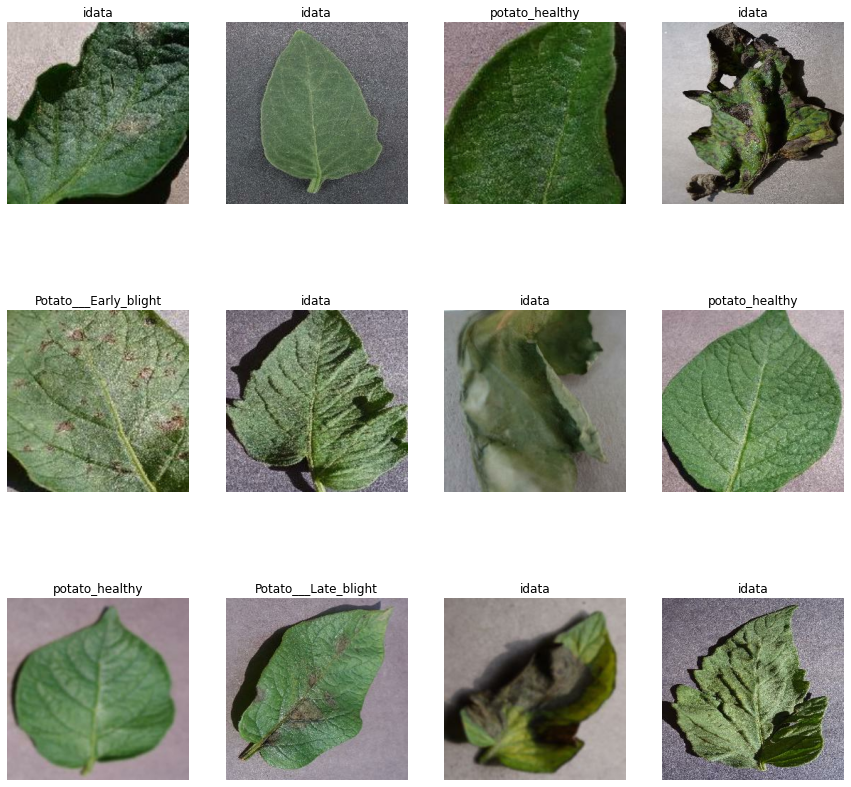

In [11]:
# Plotting the image
plt.figure(figsize = (15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image, label in dataset.take(1): 
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time =>subpots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to intiger type as they were in float.
        plt.title(class_name[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph

In [12]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.3, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_data, val_data, test_data = split_dataset(dataset)

In [14]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :459 
Batch size of Training Data is :137
Batch size of Validation Data is :45 
Batch size of Testing Data is :277 


In [15]:
# caching,shuffle and prefetching the data
train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.2)
])

In [18]:
# Creating Convolution layer 
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [20]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [21]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/10
137/137 [==============================] - 421s 3s/step - loss: 1.2830 - accuracy: 0.5732 - val_loss: 1.0314 - val_accuracy: 0.5701
Epoch 2/10
137/137 [==============================] - 413s 2s/step - loss: 0.9724 - accuracy: 0.6225 - val_loss: 0.9522 - val_accuracy: 0.6687
Epoch 3/10
137/137 [==============================] - 414s 2s/step - loss: 0.8560 - accuracy: 0.6583 - val_loss: 0.7232 - val_accuracy: 0.7201
Epoch 4/10
137/137 [==============================] - 409s 2s/step - loss: 0.6813 - accuracy: 0.7393 - val_loss: 0.7383 - val_accuracy: 0.7245
Epoch 5/10
137/137 [==============================] - 430s 3s/step - loss: 0.6125 - accuracy: 0.7555 - val_loss: 0.7322 - val_accuracy: 0.7243
Epoch 6/10
137/137 [==============================] - 417s 3s/step - loss: 0.5614 - accuracy: 0.7735 - val_loss: 0.6076 - val_accuracy: 0.7542
Epoch 7/10
137/137 [==============================] - 400s 2s/step - loss: 0.5018 - accuracy: 0.7924 - val_loss: 0.4984 - val_accuracy: 0.7944

In [22]:
scores = model.evaluate(train_data)

137/137 [==============================] - 190s 811ms/step - loss: 0.4168 - accuracy: 0.8221


In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 137}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

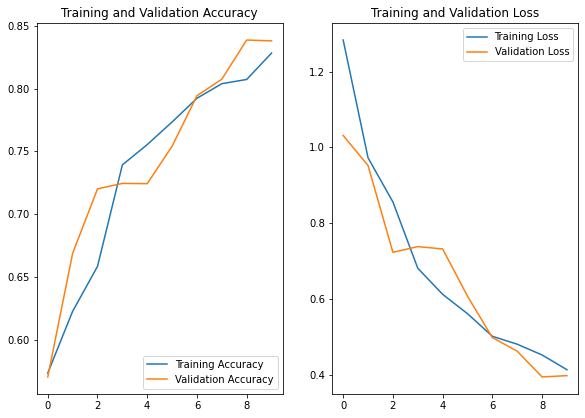

In [28]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(Epochs), train_acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(Epochs), train_loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  idata
Predicted label :  idata


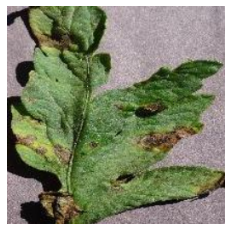

In [29]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')

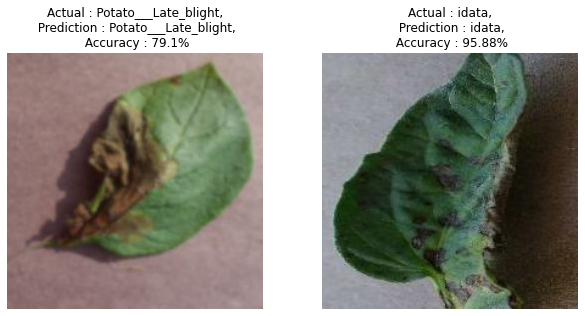

In [30]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(2):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Accuracy : {confidence}%')
    
        plt.axis('off')

In [31]:
model.save("potato_disease_detection")

INFO:tensorflow:Assets written to: potato_disease_detection\assets
